# **Computer Vision** | MSc in Data Science and Engineering
## Assignment 2 - CAPTCHA Decoding
### Bruno Silva (up201508756) **|** João Carvalho (up201507023)
##### November, 2024


# TO DO
- Tempos de treino no colab
- explicar porquê que a accuracy dá diferente

## Introduction


On this project we aim at creating a system that automatically decodes CAPTCHA images. These images depict 4 or 5 characters that can be either letters or numbers that have a somewhat distorted shape and, on top of that, the images have some noise similar to salt-and-pepper noise. The dataset is divided into two subsets, the "soft" set and the "hard" set - this latter one has an additional layer of difficulty in the sense that most images have a random line crossing most of the image. \
Our main goal was to develop a system where the input is one CAPTCHA image and the output is, for instance, "84a9h". For this, several things have to be taken into consideration:
- **Number of characters in the image** - some images have 4 characters while others have 5 characters. This poses a problem since in most end-to-end approaches we would need a fixed output length - for example, a set of convolutional layers and 4 or 5 classifiers at the end. We could fix the output length to 5 and add a \<PAD> character that would fill the gap in the case the image having only 4 characters but even then, each clasifier would have to be aware of its "responsability" for each character in order which probably wouldn't work very well.
- **Order** - Regardless of the method used, the output would have to keep a sense of order since detecting the characters by themselves is not enough for the system to function well. The original order of the characters in the image would have to be recognized and kept as well.

Our methodology deals with both issues at the same time. We start by segmenting the images into their several characters using OpenCV's contours methods and keep the order of these characters based on their contour's value on the *x* axis of the image. This way we can train a model to recognize individual characters and pass these characters to the trained model in the correct order so they can be decoded one by one. The output of the system is the concatenated predicionts of every character in the picture. \
The models trained had remarkable performance on a character level and acceptable-to-good performance on an image level.

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as func
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from torch import nn
import pandas as pd
import numpy as np
import cv2 as cv
import random
import shutil
import torch
import time
import os

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Utility functions

In [28]:
# morphological operations

def dilate(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_dilated = cv.dilate(array2, kernel, iterations=1) #dilate
    return array_dilated

def erode(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_eroded = cv.erode(array2, kernel, iterations=1) #erode
    return array_eroded

In [29]:
def segment_char(img_name, data_folder):

    img_path = os.path.join(data_folder, img_name)

    # image to grayscale
    image = cv.imread(img_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # thresholding
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # morphological operations and median blur for the "hard" images
    thresh = dilate(erode(thresh, 2), 2) if "hard" in data_folder else thresh
    thresh = cv.medianBlur(src=thresh, ksize=3) if "hard" in data_folder else thresh

    # contours detection
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # applying a threshold to remove small contours
    threshold = 100
    contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

    # creating individual images based on the bounding boxes
    individual_images = []
    x_values = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        x_values.append(x)
        individual_image = image[y:y+h, x:x+w]
        individual_images.append(individual_image)

    # get the sorted idx of x_values -> this is to order the images from left to right, otherwise the contours are ordered in some other way
    sorted_idx = np.argsort(x_values)
    # sort individual_images based on sorted_idx
    individual_images = [individual_images[i] for i in sorted_idx]

    # save individual images
    full_img_name = img_name.split('.')[0]

    return individual_images, full_img_name

def save_images(individual_images, data_folder, full_img_name, img_name):

    # new folder for individual images
    new_data_folder = data_folder + "_char"

    # If the pre-processing is not done correctly, we have a different number of images and characters
    # So, we raise an error for the following step
    if len(individual_images) != len(full_img_name):
        raise ValueError()

    for i, img in enumerate(individual_images):
        char = img_name[i]
        cv.imwrite(f'{new_data_folder}/{char}_{full_img_name}_{i}.png', img)

## Pre-processing (DO NOT RUN)
This is for the initial segmentation of each image into individual characters for training purposes. In colab this is very slow and unreliable to run (it doesn't manage the upload of 30000+ images well). We also tried using Google Drive as the source of the data but PyTorch's DataLoader is extremely slow on fetching the data from the drive. Our solution was to run the segmentation locally and save everything in a zip file with the character images instead. The unzipping of the zip files is done below and works well with colab.

In [27]:
## Creation of validation set
train_data_folder_soft = "CAPTCHA_dataset/soft/train"
validation_data_folder_soft = "CAPTCHA_dataset/soft/validation"
train_data_folder_hard = "CAPTCHA_dataset/hard/train"
validation_data_folder_hard = "CAPTCHA_dataset/hard/validation"

pairs = [
    (train_data_folder_soft, validation_data_folder_soft),
    (train_data_folder_hard, validation_data_folder_hard)
]

for train_data_folder, validation_data_folder in pairs:
    # choose 20% of the training folder and 
    train_files = os.listdir(train_data_folder)
    random.seed(10) # for reproducibility
    validation_files = random.sample(train_files, int(len(train_files) * 0.2))

    # move to the validateion folder
    for file in validation_files:
        src = os.path.join(train_data_folder, file)
        dst = os.path.join(validation_data_folder, file)
        shutil.move(src, dst)

In [30]:
data_folders = ["CAPTCHA_dataset/soft/", "CAPTCHA_dataset/hard/"]
count_soft = 0
count_hard = 0

hard_wrong_pp = []

for data_folder in data_folders:

    for sub_folder in ['train', 'validation', 'test']:

        iter_data_folder = data_folder + sub_folder

        for img in os.listdir(iter_data_folder):
            try:
                individual_images, full_img_name = segment_char(img, iter_data_folder)
                save_images(individual_images, iter_data_folder, full_img_name, img) # if the error is raised, we continue for the next iteration, ignoring this image
            except:
                if 'soft' in data_folder:
                    count_soft += 1
                else:
                    hard_wrong_pp.append(img)
                    count_hard += 1
                continue

In [31]:
print(f'A total of {count_soft} images were discarded from the soft dataset and {count_hard} from the hard dataset.')

A total of 932 images were discarded from the soft dataset and 1664 from the hard dataset.


After segmenting each CAPTCHA image into distinct characters using OpenCV and contour methods we noticed in a few rare examples we would have the issue overlapping characters. This is a problem because if characters overlap, there will be only one contour for two different characters which will segment the image incorrectly. With an incorrect segmentation, the labels (which are extracted from the CAPTCHA image's name) will also be incorrect from that character onwards. \
To solve this issue we tried to find a way to systematically improve the segmentation by separating the characters using methods like erosion or watershed but this didn't prove effective in most cases. We found no way of systematically improve the segmentation of the images in the "soft" dataset. \
In order to have only high quality data in the training process we decided to remove these cases from the dataset and keep only the segmentations that had the same number of contours as they had characters. This removed 932 images from the whole "soft" dataset (train, validation and test sets) from a total of 7773 which is not too bad as the vast makority was kept. \
\
After this, we started looking into the "hard" dataset and realized we would have to adjust the approach since many of the images had a random line over the characters which most of the times served as a bridge for the contour to connect several characters together - sometimes all the characters in the image would be covered by the same contour generating just one contour and making the segmentation impossible. For reference, our initial approach that was applied to the "soft" dataset would discard 5885 images out of the 7087 of the whole dataset, which is not acceptable.\
To mitigate the problem we understood that morphological operations could indeed help in this case since we are aiming at getting rid of the fine line that sometimes covers the characters. Even if we damaged the exact character shape in the process, all we needed was to keep at least a bit of that shape for a good contour to be detected and at the same time eliminate the overlaying line from the image altogether. After iterating on erosion and dilation with several kernel sizes we found some success but eventually found that applying a median blur filter would render similar results. By using both of these methods we achieved the best results and lowered the number of 5885 discarded images to 1664 which, although not perfect, is a huge improvement. We tried this on the "soft" dataset as well but didn't find any combination that would improve the segmentation any further.

NOTE: These misclassifications due to the pre-processing of the images will be accounted for in some of the evaluation metrics presented later on.

## Data

On this section we create the DataLoader objects necessary to develop the model.

In [32]:
# Unzipping the datasets
'''
This will unzip train_char.zip and test_char.zip both from the hard folder and soft folder.
Make sure to have a CAPTCHA_dataset folder with a /hard and /soft folders inside in the colab directory created before running this cell.
'''
from zipfile import ZipFile

for folder in ["train", "test"]:

    with ZipFile(f"{folder}_char.zip", 'r') as zObject:

        zObject.extractall(path="CAPTCHA_dataset/soft/")

FileNotFoundError: [Errno 2] No such file or directory: 'train_char.zip'

In [33]:
# to check if all the images are there
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/train_char')])) # should be 20119
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/validation_char')])) # should be 4963
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/test_char')])) # should be 5623
print()
print(len([name for name in os.listdir('CAPTCHA_dataset/hard/train_char')])) # should be 15505
print(len([name for name in os.listdir('CAPTCHA_dataset/hard/validation_char')])) # should be 3846
print(len([name for name in os.listdir('CAPTCHA_dataset/hard/test_char')])) # should be 4974

8258
16824
5623

12417
6934
4974


In [34]:
char_map = {ch: idx for idx, ch in enumerate("0123456789abcdefghijklmnopqrstuvwxyz")}
idx_to_char = {idx: ch for ch, idx in char_map.items()}  # Reverse mapping

char_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [35]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # getting all image paths and labels
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)

            self.image_paths.append(img_path)

            label = img_name[0] # removing the .png from the name and choosing the first character
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths) # to get the len(dataset)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label = torch.tensor(char_map[label], dtype=torch.long) # with this we don't need the collate function we had initially
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label

In [37]:
transform = transforms.Compose([
    transforms.Resize((32, 16)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [38]:
# Soft dataset
train_dir_soft = 'CAPTCHA_dataset/soft/train_char'
val_dir_soft = 'CAPTCHA_dataset/soft/validation_char'
test_dir_soft = 'CAPTCHA_dataset/soft/test_char'

train_dataset_soft = CaptchaDataset(root_dir=train_dir_soft, transform=transform)
val_dataset_soft = CaptchaDataset(root_dir=val_dir_soft, transform=transform)
test_dataset_soft = CaptchaDataset(root_dir=test_dir_soft, transform=transform)

train_loader_soft = DataLoader(train_dataset_soft, batch_size=32, shuffle=True, num_workers=0)
val_loader_soft = DataLoader(val_dataset_soft, batch_size=32, shuffle=False, num_workers=0)
test_loader_soft = DataLoader(test_dataset_soft, batch_size=32, shuffle=False, num_workers=0)

# Hard dataset
train_dir_hard = 'CAPTCHA_dataset/hard/train_char'
val_dir_hard = 'CAPTCHA_dataset/hard/validation_char'
test_dir_hard = 'CAPTCHA_dataset/hard/test_char'

train_dataset_hard = CaptchaDataset(root_dir=train_dir_hard, transform=transform)
val_dataset_hard = CaptchaDataset(root_dir=val_dir_hard, transform=transform)
test_dataset_hard = CaptchaDataset(root_dir=test_dir_hard, transform=transform)

train_loader_hard = DataLoader(train_dataset_hard, batch_size=32, shuffle=True, num_workers=0)
val_loader_hard = DataLoader(val_dataset_hard, batch_size=32, shuffle=False, num_workers=0)
test_loader_hard = DataLoader(test_dataset_hard, batch_size=32, shuffle=False, num_workers=0)

In [39]:
print('Soft dataset size')
print('Training:', len(train_dataset_soft))
print('Validation:', len(val_dataset_soft))
print('Test:', len(test_dataset_soft))
print()
print('Hard dataset size')
print('Training:', len(train_dataset_hard))
print('Validation:', len(val_dataset_hard))
print('Test:', len(test_dataset_hard))

Soft dataset size
Training: 8258
Validation: 16824
Test: 5623

Hard dataset size
Training: 12417
Validation: 6934
Test: 4974


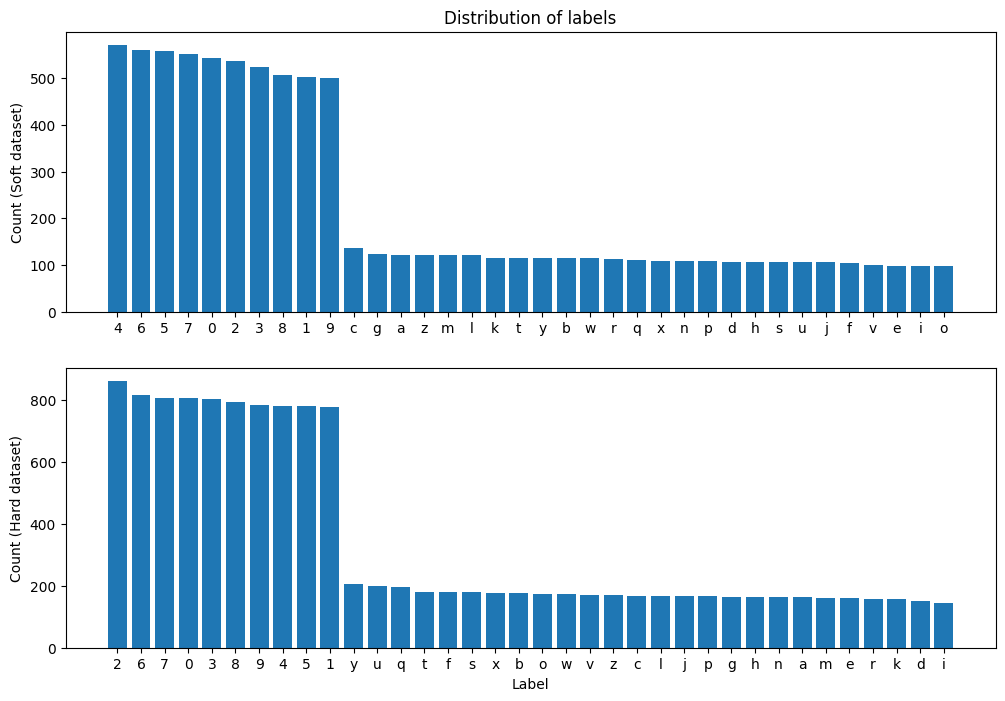

In [40]:
value_counts_soft = pd.Series(train_dataset_soft.labels).value_counts()
value_counts_hard = pd.Series(train_dataset_hard.labels).value_counts()

# plot the distribution of the labels
plt.figure(figsize=(12, 8))
# sns.barplot(x=value_counts.index, y=value_counts.values)
plt.subplot(2, 1, 1)
plt.bar(value_counts_soft.index, value_counts_soft.values)
plt.title('Distribution of labels')
plt.ylabel('Count (Soft dataset)')

plt.subplot(2, 1, 2)
plt.bar(value_counts_hard.index, value_counts_hard.values)
plt.xlabel('Label')
plt.ylabel('Count (Hard dataset)')

plt.show()

In terms of class imbalance, the datasets are not overall balanced, although they are balanced among letters and numbers. Overall there are much more numbers than letters which could be expected given there are only 10 possible numbers and 26 possible letters. \
Later on, we look into the implications of this imabalance.

Image Batch Shape: torch.Size([32, 3, 32, 16])


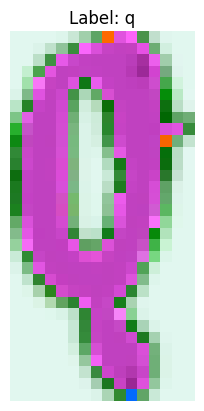

In [41]:
for images, labels in train_loader_soft:
    print("Image Batch Shape:", images.shape)

    # first image in the batch
    first_image = images[0]
    label = labels[0]

    #converting label indices back to characters
    decoded_label = idx_to_char[label.item()]

    # this is for matplotlib to display
    first_image = func.to_pil_image(first_image)

    plt.imshow(first_image)
    plt.title(f"Label: {decoded_label}")
    plt.axis('off')
    plt.show()

    break

## Model

In [43]:
# Baseline Model

class Baseline_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(Baseline_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 8, 64) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Our baseline model was built with the goal of being simple, not very big in terms of parameters and floating-point operations (FLOPs). This is just to establish an initial level of performance and see whether if a more complex model would be able to outperform it and by which degree. \
It has just two convolutional layers for feature extraction with padding of 1 to keep the image's dimensions and ReLU activation. Both layers are followed by a MaxPooling layer that halves the activaction map's width and height. After this, the classifier part of the model is composed of two fully connected layers with 64 neurons each. Below, we show the calculations for this model's number of parameters and FLOPs.

Model specs:
- Input images were resized to 32x16.
- Number of parameters: 
    - Convolutional layer 1: $3\times3\times3\times8 + 8 = 224$
    - Convolutional layer 2: $3\times3\times8\times16 + 16 = 1.168$ 
    - Fully connected layer 1: $64\times16\times4\times8 + 64 = 32.832$ 
    - Fully connected layer 2: $36\times64 + 36 = 2.340$
        - Total = $36.564$
- FLOPs:
    - Convolutional layer 1: $2\times3\times3\times3\times32\times16\times8 = 221.184$
    - Convolutional layer 2: $2\times3\times3\times8\times16\times8\times16 = 294.912$ 
    - Fully connected layer 1: $2\times16\times4\times8\times64 = 65.536$ 
    - Fully connected layer 2: $2\times64\times36 = 4.608$
        - Total = $586.240$

In [44]:
# Model Architecture

class CAPTCHA_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CAPTCHA_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 8, 256) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The second model is a little bit more complex with 3 convolutional layers for feature extraction. We keep the same overall structure of padding of 1, ReLU activation and MaxPooling after the second and third convolutional layers. For each convolutional layer, the number of kernels used is materially increased from the previous model. Regarding the fully connected layers we keep them as just 2 but increase the number of neurons to 256 for each layer. \
After experimenting with this model we noticed that the complexity of the model was starting to overfit the training data after just a few epochs of training where the performance on the training set would keep increasing whereas in the validation set it would start to materially deteriorate. To solve this problem we added two dropout layers after the second and third convolutional layers which immediately fixed the overfitting issue. \
Below we present the calculations for the parameters and FLOPs of this model and just by comparison we can see that this version has **over 30 times** more paramenters and performs **almost 70 times** as many calculations, highlighting the increase in complexity.

Model specs:
- Input images were resized to 32x16.
- Number of parameters: 
    - Convolutional layer 1: $3\times3\times3\times32 + 32 = 896$
    - Convolutional layer 2: $3\times3\times32\times64 + 64 = 18.496$
    - Convolutional layer 3: $3\times3\times64\times128 + 128 = 73.856$
    - Fully connected layer 1: $256\times128\times4\times8 + 256 = 1.048.832$ 
    - Fully connected layer 2: $36\times256 + 36 = 9.252$
        - Total = $1.151.332$
- FLOPs:
    - Convolutional layer 1: $2\times3\times3\times3\times32\times16\times32 = 884.736$
    - Convolutional layer 2: $2\times3\times3\times32\times32\times16\times64 = 18.874.368$ 
    - Convolutional layer 3: $2\times3\times3\times64\times16\times8\times128 = 18.874.368$ 
    - Fully connected layer 1: $2\times128\times4\times8\times256 = 2.097.152$ 
    - Fully connected layer 2: $2\times256\times36 = 18.432$
        - Total = $40.749.056$

In [73]:
def train(train_loader, val_loader, epochs, model, loss_fn, optimizer, model_type, dataset_type):

    max_val_accuracy = 0.0
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}

    print("Started training...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # train accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # save training history for plotting purposes
        train_history["loss"].append(running_loss / len(train_loader))
        train_history["accuracy"].append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val

        # save validation history for plotting purposes
        val_history["loss"].append(val_loss / len(val_loader))
        val_history["accuracy"].append(val_accuracy)

        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model_{model_type}_{dataset_type}.pth')

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    print("Finished")
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.2f} seconds")

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
            
def eval(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    labels_list = []
    predictions_list = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            labels_list.extend(labels.tolist())
            predictions_list.extend(predicted.tolist())

    accuracy = 100 * correct / total
    precision = precision_score(labels_list, predictions_list, average='weighted')
    recall = recall_score(labels_list, predictions_list, average='weighted')
    f1 = f1_score(labels_list, predictions_list, average='weighted')

    return accuracy, precision, recall, f1, labels_list, predictions_list

Started training...
Epoch [1/20], Train Loss: 1.5652, Train Accuracy: 59.88%, Validation Loss: 0.6666, Validation Accuracy: 80.33%
Epoch [2/20], Train Loss: 0.5436, Train Accuracy: 84.32%, Validation Loss: 0.4889, Validation Accuracy: 85.39%
Epoch [3/20], Train Loss: 0.4084, Train Accuracy: 87.88%, Validation Loss: 0.3831, Validation Accuracy: 87.97%
Epoch [4/20], Train Loss: 0.3304, Train Accuracy: 89.87%, Validation Loss: 0.3336, Validation Accuracy: 89.70%
Epoch [5/20], Train Loss: 0.2832, Train Accuracy: 91.20%, Validation Loss: 0.2845, Validation Accuracy: 90.81%
Epoch [6/20], Train Loss: 0.2423, Train Accuracy: 92.25%, Validation Loss: 0.2755, Validation Accuracy: 90.93%
Epoch [7/20], Train Loss: 0.2129, Train Accuracy: 92.97%, Validation Loss: 0.2499, Validation Accuracy: 91.62%
Epoch [8/20], Train Loss: 0.1900, Train Accuracy: 93.72%, Validation Loss: 0.2041, Validation Accuracy: 93.41%
Epoch [9/20], Train Loss: 0.1682, Train Accuracy: 94.40%, Validation Loss: 0.2115, Validatio

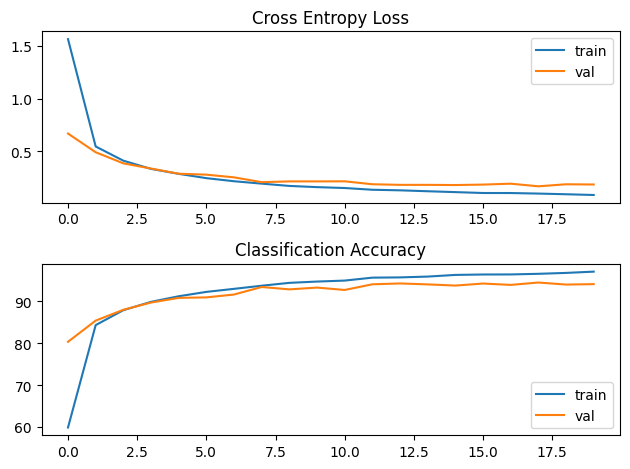

In [16]:
epochs = 20
model = Baseline_CNN(num_classes=36).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train(train_loader_soft, val_loader_soft, epochs, model, loss_fn, optimizer, 'baseline', 'soft')

Started training...
Epoch [1/20], Train Loss: 0.8503, Train Accuracy: 76.35%, Validation Loss: 0.3333, Validation Accuracy: 90.39%
Epoch [2/20], Train Loss: 0.2662, Train Accuracy: 91.49%, Validation Loss: 0.2227, Validation Accuracy: 92.79%
Epoch [3/20], Train Loss: 0.1883, Train Accuracy: 93.59%, Validation Loss: 0.1580, Validation Accuracy: 94.96%
Epoch [4/20], Train Loss: 0.1485, Train Accuracy: 94.86%, Validation Loss: 0.1421, Validation Accuracy: 95.33%
Epoch [5/20], Train Loss: 0.1230, Train Accuracy: 95.63%, Validation Loss: 0.1253, Validation Accuracy: 95.83%
Epoch [6/20], Train Loss: 0.1110, Train Accuracy: 96.04%, Validation Loss: 0.1144, Validation Accuracy: 95.79%
Epoch [7/20], Train Loss: 0.1002, Train Accuracy: 96.24%, Validation Loss: 0.1057, Validation Accuracy: 96.27%
Epoch [8/20], Train Loss: 0.0936, Train Accuracy: 96.53%, Validation Loss: 0.0972, Validation Accuracy: 96.47%
Epoch [9/20], Train Loss: 0.0875, Train Accuracy: 96.71%, Validation Loss: 0.1014, Validatio

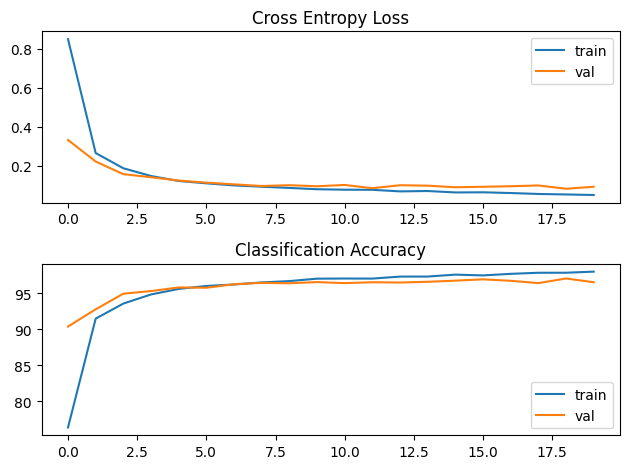

In [17]:
epochs = 20
model = CAPTCHA_CNN(num_classes=36).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train(train_loader_soft, val_loader_soft, epochs, model, loss_fn, optimizer, 'captcha', 'soft')

Started training...
Epoch [1/20], Train Loss: 1.6961, Train Accuracy: 56.99%, Validation Loss: 0.7252, Validation Accuracy: 80.21%
Epoch [2/20], Train Loss: 0.5341, Train Accuracy: 85.14%, Validation Loss: 0.5182, Validation Accuracy: 86.27%
Epoch [3/20], Train Loss: 0.4036, Train Accuracy: 88.46%, Validation Loss: 0.4092, Validation Accuracy: 89.42%
Epoch [4/20], Train Loss: 0.3342, Train Accuracy: 90.34%, Validation Loss: 0.3820, Validation Accuracy: 90.38%
Epoch [5/20], Train Loss: 0.2867, Train Accuracy: 91.74%, Validation Loss: 0.3513, Validation Accuracy: 90.95%
Epoch [6/20], Train Loss: 0.2536, Train Accuracy: 92.51%, Validation Loss: 0.3235, Validation Accuracy: 91.45%
Epoch [7/20], Train Loss: 0.2314, Train Accuracy: 93.14%, Validation Loss: 0.3204, Validation Accuracy: 92.15%
Epoch [8/20], Train Loss: 0.2109, Train Accuracy: 93.80%, Validation Loss: 0.2803, Validation Accuracy: 92.93%
Epoch [9/20], Train Loss: 0.1956, Train Accuracy: 94.10%, Validation Loss: 0.3002, Validatio

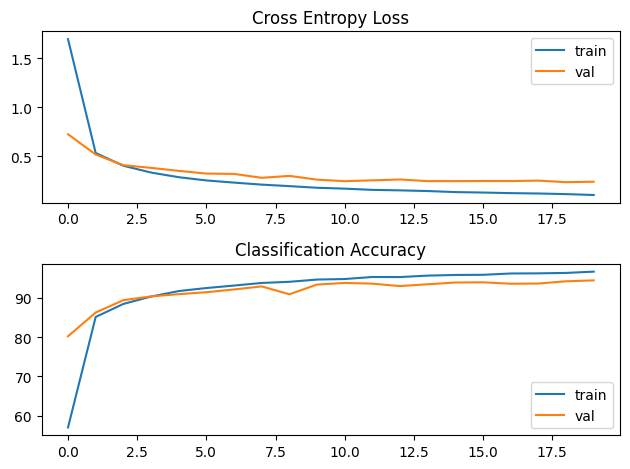

In [18]:
epochs = 20
model = Baseline_CNN(num_classes=36).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train(train_loader_hard, val_loader_hard, epochs, model, loss_fn, optimizer,  'baseline', 'hard')

Started training...
Epoch [1/20], Train Loss: 0.9859, Train Accuracy: 73.23%, Validation Loss: 0.3963, Validation Accuracy: 89.03%
Epoch [2/20], Train Loss: 0.3087, Train Accuracy: 90.85%, Validation Loss: 0.2425, Validation Accuracy: 93.79%
Epoch [3/20], Train Loss: 0.2195, Train Accuracy: 93.10%, Validation Loss: 0.2339, Validation Accuracy: 93.81%
Epoch [4/20], Train Loss: 0.1753, Train Accuracy: 94.48%, Validation Loss: 0.1945, Validation Accuracy: 94.44%
Epoch [5/20], Train Loss: 0.1564, Train Accuracy: 95.01%, Validation Loss: 0.1885, Validation Accuracy: 94.90%
Epoch [6/20], Train Loss: 0.1418, Train Accuracy: 95.29%, Validation Loss: 0.1762, Validation Accuracy: 95.42%
Epoch [7/20], Train Loss: 0.1270, Train Accuracy: 95.54%, Validation Loss: 0.1669, Validation Accuracy: 95.66%
Epoch [8/20], Train Loss: 0.1163, Train Accuracy: 96.03%, Validation Loss: 0.1645, Validation Accuracy: 95.89%
Epoch [9/20], Train Loss: 0.1076, Train Accuracy: 96.30%, Validation Loss: 0.1707, Validatio

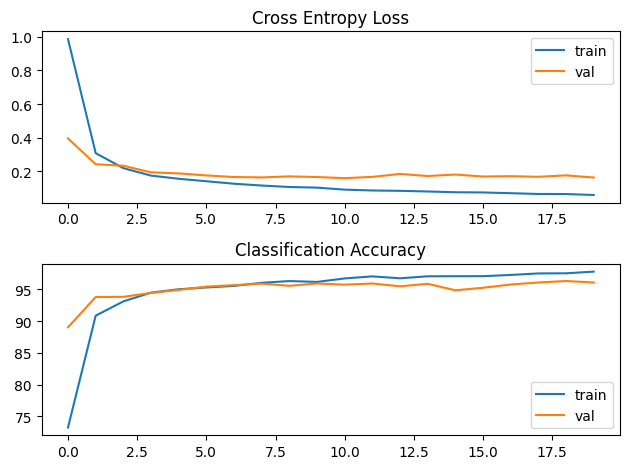

In [19]:
epochs = 20
model = CAPTCHA_CNN(num_classes=36).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train(train_loader_hard, val_loader_hard, epochs, model, loss_fn, optimizer, 'captcha', 'hard')

## Results

In this section, we present the results of our experiments, which focused in two aspects of our project:

1. **Character level:** This evaluates the metrics of the Convolutional Neural Network, being a direct measure of the model's ability to analyze each carachter.

2. **Image level:** This evalutes not only the model but also the pre processing. This is the real-life test, showing the capability of this method to decode the CAPTCHA - For this case, if one label of the 4/5 labels of the CAPTCHA image is detected incorrectly we will consider the image as a wrong sample.

By combining these evaluations, we can provide the analysis of the CNN and the robustness of the overall approach.

### 1. Character Level

Starting for the first case we will purely analyze the metrics obtained by the model. Calculating the accuracy, precision, recall and f1 score.

In [58]:
# Loading the 4 models

model_baseline_soft = Baseline_CNN(num_classes=36).to(device)
model_baseline_soft.load_state_dict(torch.load('best_model_baseline_soft.pth'))

model_captcha_soft = CAPTCHA_CNN(num_classes=36).to(device)
model_captcha_soft.load_state_dict(torch.load('best_model_captcha_soft.pth'))

model_baseline_hard = Baseline_CNN(num_classes=36).to(device)
model_baseline_hard.load_state_dict(torch.load('best_model_baseline_hard.pth'))

model_captcha_hard = CAPTCHA_CNN(num_classes=36).to(device)
model_captcha_hard.load_state_dict(torch.load('best_model_captcha_hard.pth'))

models = {
    model_baseline_soft: ['baseline', 'soft'],
    model_captcha_soft: ['captcha', 'soft'],
    model_baseline_hard: ['baseline', 'hard'],
    model_captcha_hard: ['captcha', 'hard']
}

C:\Users\uih03098\AppData\Local\Temp\ipykernel_22264\2914911392.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline_soft.load_state_dict(torch.load('best_mode

In [ ]:
accuracies_char = {
    'Model type': [],
    'Dataset': [],
    'Train accuracy': [],
    'Validation accuracy': [],
    'Test accuracy': [],
    'Test precision': [],
    'Test recall': [],
    'Test f1': []
}

for model in models.keys():

    if models[model][1] == 'soft':
        train_accuracy, train_precision, train_recall, train_f1, _, _ = eval(train_loader_soft, model)
        val_accuracy, val_precision, val_recall, val_f1, _, _ = eval(val_loader_soft, model)
        test_accuracy, test_precision, test_recall, test_f1, _, _ = eval(test_loader_soft, model)

    elif models[model][1] == 'hard':
        train_accuracy, train_precision, train_recall, train_f1, _, _ = eval(train_loader_hard, model)
        val_accuracy, val_precision, val_recall, val_f1, _, _ = eval(val_loader_hard, model)
        test_accuracy, test_precision, test_recall, test_f1, _, _ = eval(test_loader_hard, model)

    accuracies_char['Model type'].append(models[model][0])
    accuracies_char['Dataset'].append(models[model][1])
    accuracies_char['Train accuracy'].append(train_accuracy)
    accuracies_char['Validation accuracy'].append(val_accuracy)
    accuracies_char['Test accuracy'].append(test_accuracy)
    accuracies_char['Test precision'].append(test_precision)
    accuracies_char['Test recall'].append(test_recall)
    accuracies_char['Test f1'].append(test_f1)

    # print(f"Train accuracy: {train_accuracy:.2f}%") # como é que está a dar diferente do de cima?
    # print(f"Validation accuracy: {val_accuracy:.2f}%")
    # print(f"Test accuracy: {test_accuracy:.2f}%")

In [68]:
char_df = pd.DataFrame(accuracies_char)
char_df['Train accuracy'] = char_df['Train accuracy'].round(2).astype(str) + '%'
char_df['Validation accuracy'] = char_df['Validation accuracy'].round(2).astype(str) + '%'
char_df['Test accuracy'] = char_df['Test accuracy'].round(2).astype(str) + '%'
char_df['Test precision'] = char_df['Test precision'].round(2).astype(str)
char_df['Test recall'] = char_df['Test recall'].round(2).astype(str)
char_df['Test f1'] = char_df['Test f1'].round(2).astype(str)
char_df

,Model type,Dataset,Train accuracy,Validation accuracy,Test accuracy,Test precision,Test recall,Test f1
0,baseline,soft,97.3%,96.31%,94.77%,0.94,0.95,0.94
1,captcha,soft,99.1%,98.47%,96.85%,0.97,0.97,0.97
2,baseline,hard,96.96%,95.59%,94.29%,0.94,0.94,0.94
3,captcha,hard,98.63%,97.39%,95.56%,0.95,0.96,0.95


- Looking at the model type, we can see that the Captcha model outperforms the Baseline model in both data types. This demonstrates that increasing the number of parameters leads to better results for this case study.

- When analyzing the datasets, as expected, the soft dataset achieved better results compared to the Hard dataset, which reflects the latter's higher complexity.

- Looking for the precision, recall and f1 we can observe a consistently high and balanced performance across all test scenarios wich not showing a tendency for FN or FP.

- Another interesting observation is that the train, validation, and test accuracies are all very close to each other. This indicates minimal to no overfitting in the models, showcasing their strong generalization ability.

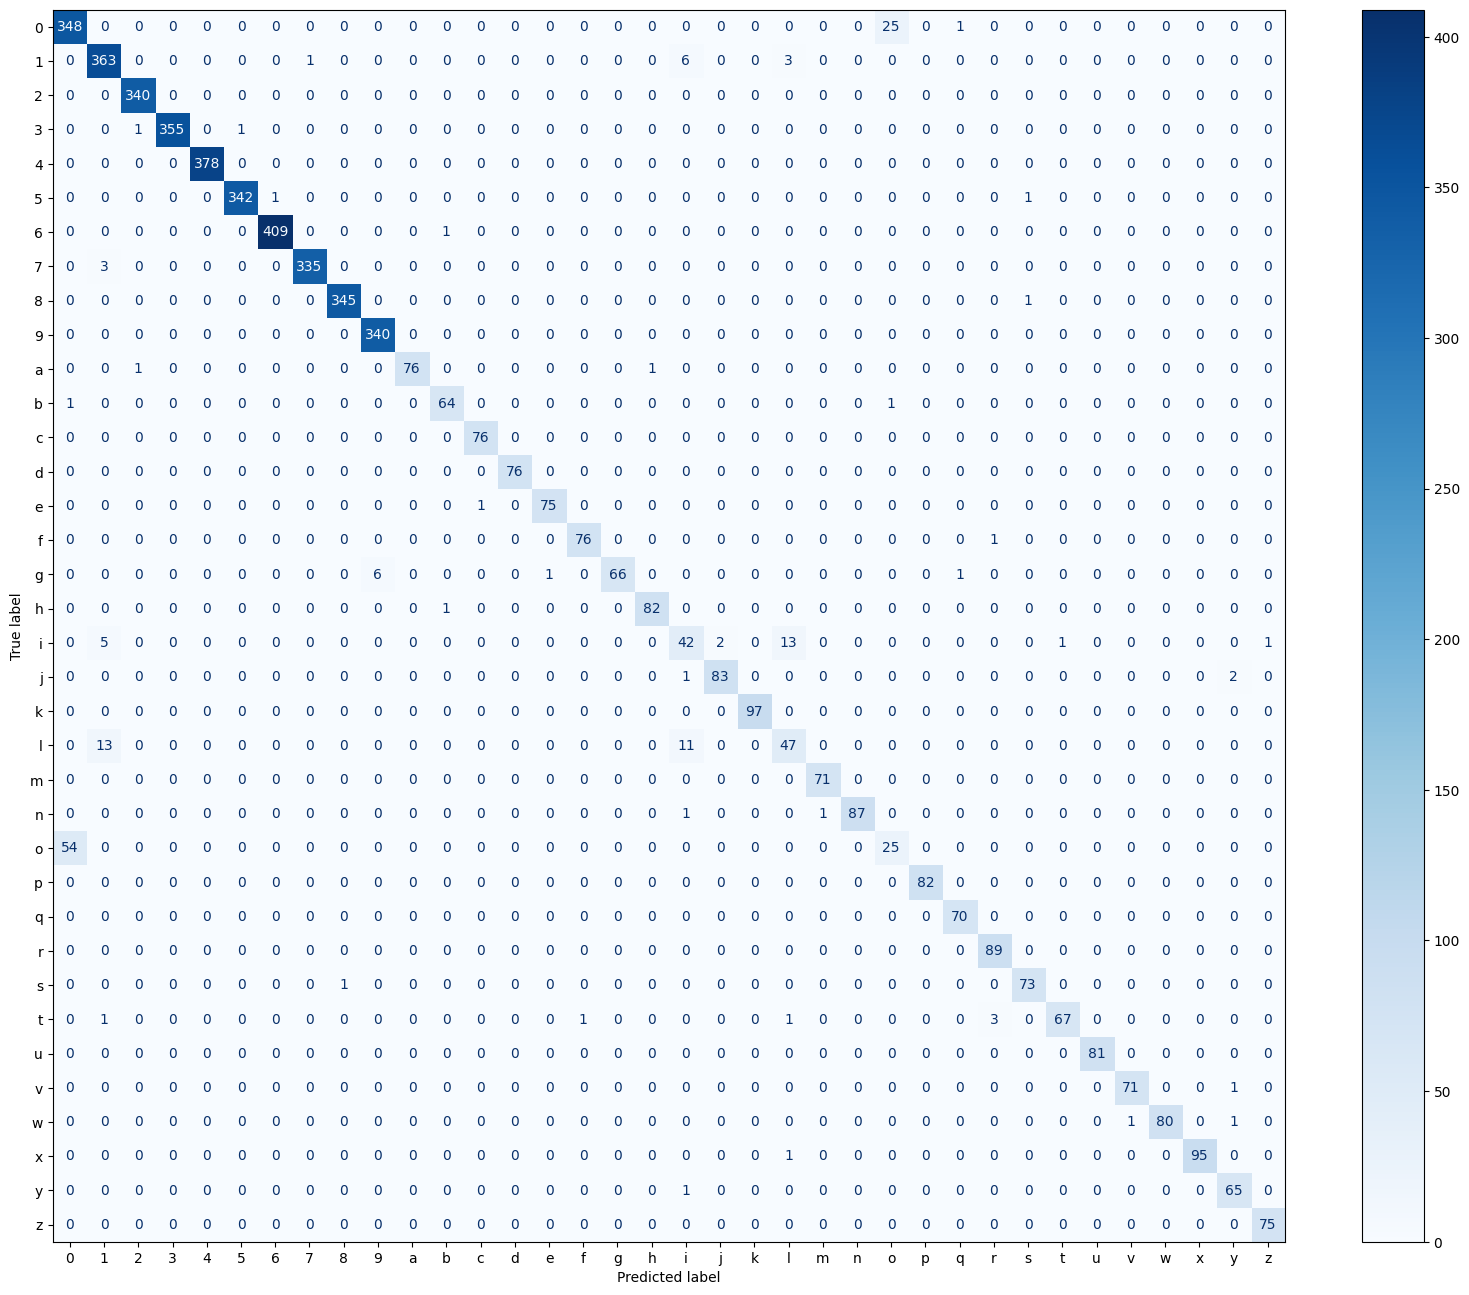

In [82]:
def plot_confusion_matrix(labels, pred_labels, class_labels):
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels, labels=class_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=class_labels)
    cm.plot(values_format='d', cmap='Blues', ax=ax)

_, _, _, _, labels, predictions = eval(test_loader_soft, model_captcha_soft)

# convert indexes into characters
labels = [idx_to_char[i] for i in labels]
predictions = [idx_to_char[i] for i in predictions]

# to plot the axes with the class names
class_labels = sorted(set(idx_to_char.values()))

plot_confusion_matrix(labels, predictions, class_labels)

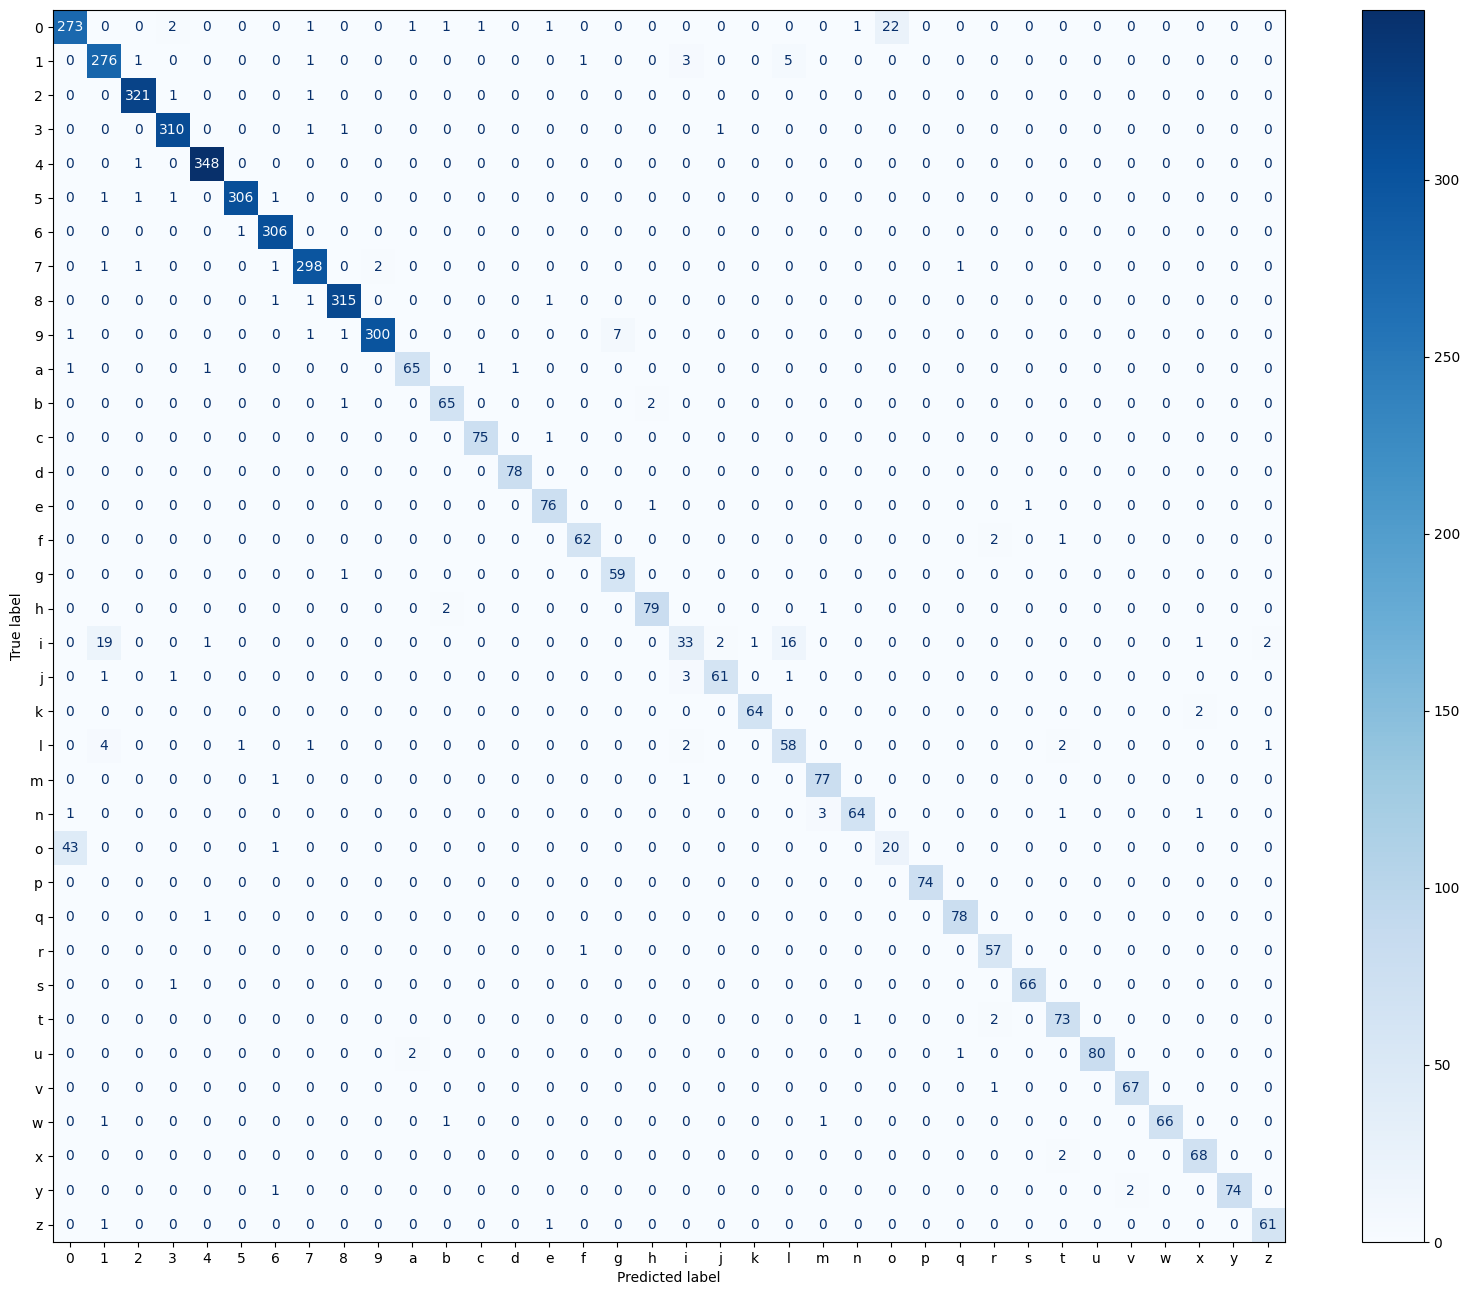

In [83]:
_,_,_,_, labels, predictions = eval(test_loader_hard, model_captcha_hard)

# convert indexes into characters
labels = [idx_to_char[i] for i in labels]
predictions = [idx_to_char[i] for i in predictions]

# to plot the axes with the class names
class_labels = sorted(set(idx_to_char.values()))

plot_confusion_matrix(labels, predictions, class_labels)

Above we present two confusion matrices applied to the test set of both the "soft" and "hard" datasets using the respective and more capable CAPTCHA_CNN model. We present it with absolute values since it is easier to understand the distribution of the classes and any issues with class imbalance. We can observe that both models are performing quite well in general at the character level due to the well defined diagonal in each matrix. In spite of it, there are two issues we can also observe:
- Most of the times, the models are predicting "0" when the image is showing "o". In the first matrix for example, out of the 79 "o" characteres, 54 were predicted as a "0". This is likely due to the class imabalance between numbers and letters. Since there are many more "0", the model chooses to predict "0" most of the time. In any case, this is understandable since both characters are very similar and in the context of the CAPTCHA images, even human level performance would be lacking because of the distortion applied to the characters. Below we show one "0" and one "o" - which is which?
- Both models are also sometimes mixing "i" with "1" or "l". Interestingly enough, it doesn't happen the other way around: "l" or "1" are almost never confused with an "i".

Which one is an "o" and which one is a "0"?


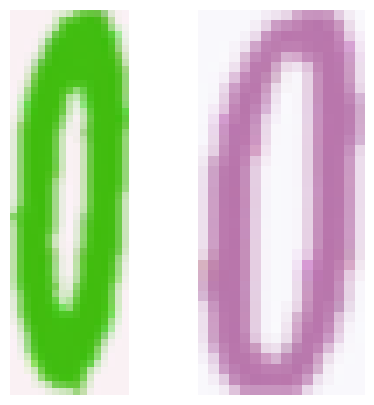

In [26]:
o_image = cv.imread("CAPTCHA_dataset/soft/test_char/o_0o0mi_1.png")
o_image = cv.cvtColor(o_image, cv.COLOR_BGR2RGB)
z_image = cv.imread("CAPTCHA_dataset/soft/test_char/0_0tqq_0.png")
z_image = cv.cvtColor(z_image, cv.COLOR_BGR2RGB)

print('Which one is an "o" and which one is a "0"?')

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(o_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(z_image)
plt.axis('off')
plt.show()

In [29]:
'''
This function can be ran at any time to test the model and classify a random character from the test set.
'''

model = model_captcha_soft

def classify_random_example(test_loader):
    model.eval()

    # choosing a random batch 
    data_list = list(test_loader)
    random_batch = np.random.randint(0, len(data_list))
    inputs, labels = data_list[random_batch]
    
    # random sample from the batch
    idx = np.random.randint(0, inputs.size(0))
    image, label = inputs[idx], labels[idx]

    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    image = image.cpu().permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f"Predicted: {idx_to_char[predicted.item()]}, Correct: {idx_to_char[label.item()]}")
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58431375..1.0].


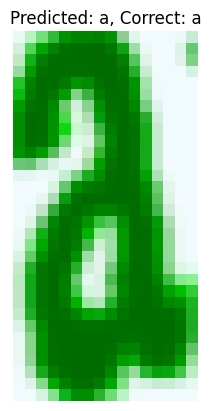

In [30]:
classify_random_example(test_loader_soft)

### 2. Image level

We also report on metrics at the image level, simulating what such a model would be used for in a real-world scenario. \
For an instance to be considered as correct, the model must correctly identify all the characters in the image on the correct order. - If the number of characters after pre-processing differs from the number of characters of the labels and/or one of the characters is missclassified we will consider all the image as wrongly classified.
Regarding metrics, in this case we only consider accuracy since by analysing the data this way - the label being the full sequence - it is not possible to obtain a confusion matrix.
It's also evaluated two different accuracies:
1. For all the data
2. Excluding the ones wrongly pre-processed

In [85]:
accuracies_full_img = {
    'Model type': [],
    'Dataset': [],
    'Accuracy (all data)': [],
    'Accuracy (pp)': []
}

In [86]:
#evaluate method

for model in models.keys():

    test_folder = "CAPTCHA_dataset/soft/test" if models[model][1] == 'soft' else "CAPTCHA_dataset/hard/test"

    pre_processing_right = 0
    pre_processing_wrong=0
    correct = 0
    wrong = 0

    for img in os.listdir(test_folder):

        # segment individual characters
        individual_images, full_img_name = segment_char(img, test_folder)
        
        # checking if pre-processing worked well
        if len(individual_images)!=len(full_img_name):
            pre_processing_wrong +=1
            wrong+=1

        # if it did, predict
        if len(individual_images)==len(full_img_name):
            pre_processing_right+=1
                    
            for i, char_img in enumerate(individual_images):
                # image to tensor
                char_img_pil = Image.fromarray(cv.cvtColor(char_img, cv.COLOR_BGR2RGB))
                char_img_tensor = transform(char_img_pil).unsqueeze(0)

                # model prediction
                with torch.no_grad():
                    outputs = model(char_img_tensor)
                    _, predicted = torch.max(outputs, 1)
                    predicted_char = idx_to_char[predicted.item()]

                # compare with ground truth
                if predicted_char != full_img_name[i]:
                    wrong += 1
                    break

                if i == len(individual_images) - 1:
                    correct += 1

    total = correct + wrong
    accuracy = (correct / total) * 100
    accuracy_tested = (correct / pre_processing_right) * 100

    accuracies_full_img['Model type'].append(models[model][0])
    accuracies_full_img['Dataset'].append(models[model][1])
    accuracies_full_img['Accuracy (all data)'].append(accuracy)
    accuracies_full_img['Accuracy (pp)'].append(accuracy_tested)

    # print(f'Accuracy (All): {accuracy:.2f}%')
    # print(f'Accuracy (Pre-processed): {accuracy_tested:.2f}%')
    # print(pre_processing_right, pre_processing_wrong)
    # print(correct)

In [56]:
full_img_df = pd.DataFrame(accuracies_full_img)
full_img_df['Accuracy (all data)'] = full_img_df['Accuracy (all data)'].round(2).astype(str) + '%'
full_img_df['Accuracy (pp)'] = full_img_df['Accuracy (pp)'].round(2).astype(str) + '%'
full_img_df

,Model type,Dataset,Accuracy (all data),Accuracy (pp)
0,baseline,soft,69.34%,79.19%
1,captcha,soft,75.7%,86.44%
2,baseline,hard,61.48%,79.37%
3,captcha,hard,64.76%,83.6%


- By analysing the complete pipeline performance we can see that the accuracy drops considerably comparing to the simple character analysis, this is expected because as already mentioned we are considering a wrong prediction if the model only misses at least one classification (character). Also, we are considering here the images that were wrongly processed which drops the accuracy comparing to the character level.

- Looking for the results, as expected the pattern stil remains: CAPTCHA_CNN outperforms the Baseline model and the models have better accuracy on the Soft dataset rather than the Hard dataset.

- It's also observed higher accuracy when we exclude the images wrongly pre-processed, showing that the errors obtained from the pre-processing are signigicantly bigger that the ones from the model. That can be shown in all model types and datasets, but specially on the hard dataset where the difference is bigger (almost a 20% difference for both model types).

Predicted CAPTCHA:  9ole
Actual CAPTCHA:  9ole


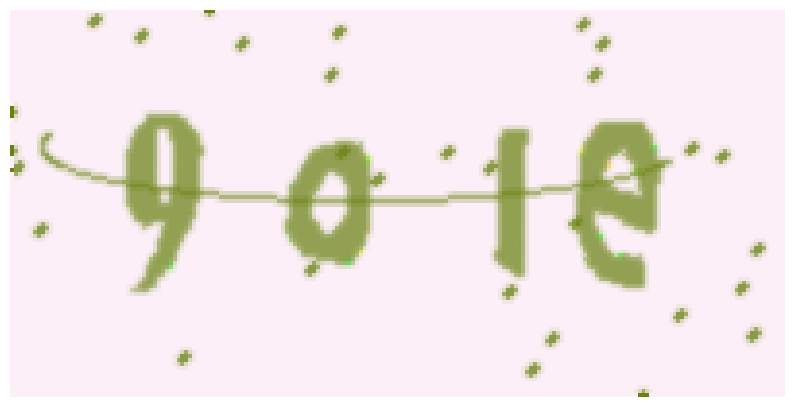

In [46]:
'''
This function can be ran at any time to test the model and classify a random character from the test set.
It will raise an error if the pre-processing doesn't perform well.
'''

model = model_captcha_hard

# choosing a random image from the test folder
test_folder = "CAPTCHA_dataset/hard/test"
img = random.choice(os.listdir(test_folder))

# segmenting the characters
individual_images, full_img_name = segment_char(img, test_folder)

# checking if the pre-processing worked
assert len(individual_images)==len(full_img_name), "Pre-processing went wrong! Please run again."

# precition
predicted_str = ""

for i, char_img in enumerate(individual_images):
    # image to tensor
    char_img_pil = Image.fromarray(cv.cvtColor(char_img, cv.COLOR_BGR2RGB))
    char_img_tensor = transform(char_img_pil).unsqueeze(0)

    # model prediction
    with torch.no_grad():
        outputs = model(char_img_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_char = idx_to_char[predicted.item()]

    predicted_str += predicted_char

print('Predicted CAPTCHA: ', predicted_str)
print('Actual CAPTCHA: ', full_img_name)

image = cv.imread(os.path.join(test_folder, img))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


## Conclusions and Limitations

On this work we were challenged to develop a model that would decode CAPTCHA images. These are images with 4 or 5 characters that have some distortion, noise similar to salt-and-pepper noise, and sometimes a random line on top of the image (the case of the "hard" dataset). To do this, we proposed two Convolutional Neural Networks, one substantially simpler than the second, to see how well this kind of approach solves the problem and how well the solution scales in complexity and performance. \
We trained a total of 4 models - the baseline and the main one for each of the two subsets of the dataset - and obtained remarkable performance at the character level with every model displaying accuracies on the 94-97% range on the test set. At the image level, the performance is obviously downgraded because $1)$ to fail an image the model has to fail just one of the characters and $2)$ the pre-processing of the image to segment each character is far from perfect. \
In terms of limitations we would point to the pre-processing just mentioned. We implemented this pre-processing step to segment the images into the unique characters which ended up not being robust to occasional overlappings of characters. This means that the characters are not properly segmented everytime there's a pre-processing failure. On these cases, we consider the model to make a wrong prediction despite the problem being from the pre-processing and not the model itself. We do this because we also wanted to evaluate the whole process, not just the CNN model's performance. The "hard" dataset made this problem worse with a random line on top of the characters which essentially connected multiple characters - sometimes all of them - into one. With some additional pre-processing for these cases with the help of morphological operations and median blur filters we were able to subtantially mitigate the problem but never bring it to the same level as in the "soft" dataset. Other than that, we think the rest of the process and the models built are effective and robust to overfitting.